<a href="https://colab.research.google.com/github/nicolassalomon96/procesamiento_imagenes_UNS/blob/main/TP8/Remuestreo_y_Cuantizaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TP8 - Remuestreo y Cuantización

Presentado: Nicolás Salomón - email: nicolassalomon96@gmail.com

Implementar un aplicativo que permita abrir una imagen y con esta obtener:

• Downsampling X2 (mostrando la imagen resultado al doble de tamaño para comparar el efecto) utilizando kernel constante, bilineal, y bicúbico.

• Upsampling X2 (mostrando la imagen original al doble de tamaño para comparar el efecto) utilizando kernel constante, bilineal, y bicúbico.

• Cuantización a cantidad de niveles de gris variable, utilizando uniforme, dithering aleatorio, y difusión del error por scan-line.

Todas las funciones de Downsamplig, Upsampling y Cuantización deben ser desarrolladas como funciones propias y NO con funciones de biblioteca. Les sugiero recorrer la imagen mediante ciclos for anidados para una fácil implementación.

##1. Librerias necesarias

In [1]:
import os
import numpy as np
import imageio as io
import matplotlib.pyplot as plt
import random
import ipywidgets as widgets
from IPython.display import display

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##2. Funciones necesarias

In [3]:
#Función para pasar de RGB a escala de grises
def rgb2gray(rgb):
  r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
  gray = 0.299 * r + 0.587 * g + 0.114 * b
  return gray

#Función para descargar imagen
def get_image(path):
  image = io.imread(path)
  image = rgb2gray(image)
  return image.astype('uint8')

#Función para plotear una imagen
def plot_image(image, title, figsize=(10,6)):
  fig, axs = plt.subplots(figsize=figsize)
  plt.imshow(image, cmap='gray')
  plt.title(title, fontsize=14)
  plt.axis('off')

#Función para plotear dos imágenes
def plot_2images(image, title_1, image_mod, title_2, figsize=(20,8)):
  fig, axs = plt.subplots(1,2,figsize=figsize)

  plt.subplot(1,2,1)
  plt.imshow(image, cmap='gray')
  plt.title(title_1, fontsize=14)
  #plt.axis('off')

  plt.subplot(1,2,2)
  plt.imshow(image_mod, cmap='gray')
  plt.title(title_2, fontsize=14)
  #plt.axis('off')  

  plt.show()

#Función para plotear tres imágenes
def plot_4images(image1, title_1, image2, title_2, image3, title_3, image4, title_4, figsize=(30,8)):
  fig, axs = plt.subplots(1,4,figsize=figsize)

  plt.subplot(1,4,1)
  plt.imshow(image1, cmap='gray')
  plt.title(title_1, fontsize=16)

  plt.subplot(1,4,2)
  plt.imshow(image2, cmap='gray')
  plt.title(title_2, fontsize=16)

  plt.subplot(1,4,3)
  plt.imshow(image3, cmap='gray')
  plt.title(title_3, fontsize=16)

  plt.subplot(1,4,4)
  plt.imshow(image4, cmap='gray')
  plt.title(title_4, fontsize=16)

  plt.show()

#Función para guardar una imagen
def save_image(image,path):
  image = image.astype('uint8')
  io.imsave(path,image)

#Funcion para crear un botón de guardado
def save_button(image,full_path,title):

  my_button = widgets.Button(description=title)
  out = widgets.Output()

  def my_button_clicked(b):
     with out:
      #Que sucede al presionar el boton
      save_image(image,full_path)     
      print("Imagen guardada")
  
  my_button.on_click(my_button_clicked)
  display(my_button,out)

In [4]:
#Función para agregar bordes alrededor de la imagen
def add_borders(image, size=3):
  '''
  image = imagen en escala de grises
  size = 3 --> agrega una fila y columna a cada lado
         5 --> agrega 2 filas y columnas a cada lado
  '''
  first_column = image[:,0]
  last_column = image[:,-1]
  image_mod = np.copy(image)

  for i in range(size//2):
    image_mod = np.insert(image_mod,0,first_column,axis=1)
    image_mod = np.insert(image_mod,image_mod.shape[1],last_column,axis=1)

  first_raw = image_mod[0,:]
  last_raw = image_mod[-1,:]

  for i in range(size//2):
    image_mod = np.insert(image_mod,0,first_raw,axis=0)
    image_mod = np.insert(image_mod,image_mod.shape[0],last_raw,axis=0)

  return image_mod.astype('uint8')

#Función para agregar un borde abajo de la imagen repitiendo la última fila
def add_down_border(image):
  new_image = np.copy(image)
  new_image = np.insert(new_image,-1,image[-1,:], axis=0)
  return new_image.astype('uint8')  

#Función para agregar un borde a la derecha de la imagen repitiendo la última columna
def add_right_border(image):
  new_image = np.copy(image)
  new_image = np.insert(new_image,-1,image[:,-1], axis=1)
  return new_image.astype('uint8')  

#Función para realizar el downsampling de la imagen
def downsampling(kernel,image):

  if kernel == 'constante':

    #Para este kernel, si la imagen tiene un número impar de filas o columnas es necesario hacer un padding 
    #para que al recorrer de a dos pixeles no tengamos un error
    if (image.shape[0] % 2) == 1:
      image = add_down_border(image)
    if (image.shape[1] % 2) == 1:
      image = add_right_border(image)

    element_size = 2
    image_out = np.zeros([image.shape[0]//2,image.shape[1]//2])
    
    for x in range(0,image.shape[0], element_size):
      fila = x // 2
      for y in range(0,image.shape[1], element_size):
        columna = y // 2 
        box = image[x:x+element_size, y:y+element_size]
        pixel = box[0,0]
        image_out[fila,columna] = pixel
  
    image_out = np.clip(image_out,0,255)
    return image_out.astype('uint8')

  if kernel == 'bilineal':

    #Para este kernel, si la imagen tiene un número impar de filas o columnas es necesario hacer un padding 
    #para que al recorrer de a dos pixeles no tengamos un error
    if (image.shape[0] % 2) == 1:
      image = add_down_border(image)
    if (image.shape[1] % 2) == 1:
      image = add_right_border(image)
      
    element_size = 2
    image_out = np.zeros([image.shape[0]//2,image.shape[1]//2])

    for x in range(0,image.shape[0], element_size):
      fila = x // 2
      for y in range(0,image.shape[1], element_size):
        columna = y // 2 
        box = image[x:x+element_size, y:y+element_size]
        box = box.astype(int)
        pixel = np.mean(box)
        image_out[fila,columna] = pixel
  
    image_out = np.clip(image_out,0,255)
    return image_out.astype('uint8')


  if kernel == 'bicubico':

    matrix = np.array([[-1/8,5/8,5/8,-1/8]])
    bicubic_matrix = matrix * np.transpose(matrix)
    element_size = 4
    image_out = np.zeros([image.shape[0]//2,image.shape[1]//2])
    new_image = add_borders(image,5)

    for x in range(2,new_image.shape[0]-3,2):
      fila = (x-2) // 2
      for y in range(2,new_image.shape[1]-3,2):
        columna = (y-2) // 2

        box = new_image[x:x+element_size, y:y+element_size]
        pixel = np.sum(box * bicubic_matrix)
        pixel = int(pixel)
        image_out[fila, columna] = pixel

    image_out = np.clip(image_out,0,255)
    return image_out.astype('uint8')

#Función para realizar un upsampling de la imagen
def upsampling(kernel,image):

  if kernel == 'constante':
    element_size = 2
    image_out = np.zeros([image.shape[0]*2,image.shape[1]*2])
    for x in range(0,image.shape[0]):
      fila = x * 2
      for y in range(0,image.shape[1]):
        columna = y * 2
        pixel = image[x,y]
        image_out[fila:fila+element_size, columna:columna+element_size] = pixel
  
    image_out = np.clip(image_out,0,255)
    return image_out.astype('uint8')

  if kernel == 'bilineal':
    element_size = 2
    image_out = np.zeros([image.shape[0]*2,image.shape[1]*2])
    new_image = add_borders(image) #Para resolver el problema ocasionado al llegar al borde la imagen, se duplican los valores al llegar al borde
    
    for x in range(1,new_image.shape[0]-1):
      fila = (x-1) * 2
      for y in range(1,new_image.shape[1]-1):
        columna = (y-1) * 2

        box = new_image[x:x+element_size, y:y+element_size]
        box = box.astype(int)
        pixel_00 = box[0,0]
        pixel_01 = (box[0,0] + box[0,1])//2
        pixel_10 = (box[0,0] + box[1,0])//2
        pixel_11 = int(np.mean(box))
        new_box = np.array([[pixel_00,pixel_01],[pixel_10,pixel_11]])
        image_out[fila:fila+element_size, columna:columna+element_size] = new_box
    
    image_out = np.clip(image_out,0,255)
    return image_out.astype('uint8')

  if kernel == 'bicubico':

    matrix = np.array([[-1/8,5/8,5/8,-1/8]])
    bicubic_matrix = matrix * np.transpose(matrix)

    image_out = np.zeros([image.shape[0]*2,image.shape[1]*2])
    new_image = add_borders(image,5) #Para resolver el problema ocasionado al llegar al borde la imagen, se duplican los valores al llegar al borde
    
    for x in range(2,new_image.shape[0]-2):
      fila = (x-2) * 2
      for y in range(2,new_image.shape[1]-2):
        columna = (y-2) * 2

        box = new_image[x-1:x+3, y-1:y+3]
        box = box.astype(int)

        pixel_00 = box[1,1]
        pixel_01 = (-1/8)*box[1,0] + (5/8)*box[1,1] + (5/8)*box[1,2] - (1/8)*box[1,3]
        pixel_10 = (-1/8)*box[0,1] + (5/8)*box[1,1] + (5/8)*box[2,1] - (1/8)*box[3,1]
        pixel_11 = np.sum(box * bicubic_matrix)

        new_box = np.array([[pixel_00,pixel_01],[pixel_10,pixel_11]]).astype(int)

        image_out[fila:fila+2, columna:columna+2] = new_box
    
    image_out = np.clip(image_out,0,255)
    return image_out.astype('uint8')

#Función para realizar la cuantización uniforme de una imagen
def quantize_uniform(image, nivel):
    #Me posiciono en el medio de los bins y evaluo que valor asignarle al pixel

    image_out = np.copy(image)
    bins = np.linspace(0,255,nivel).astype(int)
    bins_mod = bins[1:]
    for x in range(0,image.shape[0]):
      for y in range(0,image.shape[1]):
        for i in range(len(bins)):
          if image[x,y] >= bins[i] and image[x,y] <= (bins[i] + bins[i+1])/2:
            image_out[x,y] = bins[i]
            break
          elif image[x,y] <= bins[i+1]:
            image_out[x,y] = bins[i+1]
            break
    return image_out.astype('uint8')

#Función para implementar el dithering aleatorio en una imagen
def random_noise(image,prob):
    #prob = umbral inferior

    image_output = np.zeros(image.shape)
    threshold = 1 - prob

    for i in range(image.shape[0]):
      for j in range(image.shape[1]):
          rdn = random.random()
          if rdn < prob:
              image_output[i][j] = 0
          elif rdn > threshold:
              image_output[i][j] = 255
          else:
              image_output[i][j] = image[i][j]

    return image_output.astype('uint8')

#Función para implementar la difusión del error
def error_diffusion(image,n):

  image = image/255
  image_output = np.zeros(image.shape)

  for i in range(0,image.shape[0]):
    error = 0
    for j in range(0,image.shape[1]):
      image_output[i,j] = round(image[i,j] * (n-1) + error)/(n-1)
      error = error - image_output[i,j] + image[i,j]
  
  image_output = image_output * 255
  image_output = np.clip(image_output,0,255)
  return image_output.astype('uint8')

##3. Aplicativo interactivo sobre Remuestreo y Reconstrucción

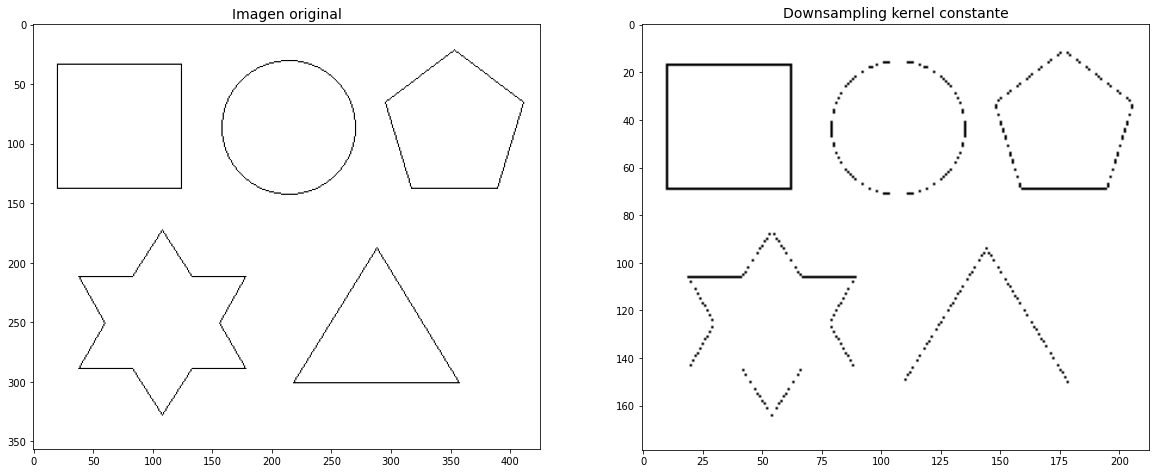

Button(description='SAVE OUTPUT', style=ButtonStyle())

Output()

In [24]:
#@title Seleccione la imagen a analizar: { run: "auto" }
circulos = '/content/drive/MyDrive/Cursos_Posgrado/Procesamiento_Imagenes-UNS/TP8/circulos.png'
formas = '/content/drive/MyDrive/Cursos_Posgrado/Procesamiento_Imagenes-UNS/TP8/formas.png'

Imagen = 'formas' #@param ["circulos", "formas"]

if Imagen =='circulos':
  image = get_image(circulos)
if Imagen =='formas':
  image = get_image(formas)#io.imread(patron)

#@markdown Seleccione el tipo de remuestreo: { run: "auto" }
Remuestreo = 'downsampling_constante' #@param ["downsampling_constante", "downsampling_bilineal", "downsampling_bicubico", "upsampling_constante", "upsampling_bilineal", "upsampling_bicubico"]

if Remuestreo == 'downsampling_constante':
  image_out = downsampling('constante',image)
  plot_2images(image,'Imagen original',image_out,'Downsampling kernel constante')

if Remuestreo == 'downsampling_bilineal':
  image_out = downsampling('bilineal',image)
  plot_2images(image,'Imagen original',image_out,'Downsampling kernel bilineal')

if Remuestreo == 'downsampling_bicubico':
  image_out = downsampling('bicubico',image)
  plot_2images(image,'Imagen original',image_out,'Downsampling kernel bicubico')

if Remuestreo == 'upsampling_constante':
  image_out = upsampling('constante',image)
  plot_2images(image,'Imagen original',image_out,'Upsampling kernel constante')

if Remuestreo == 'upsampling_bilineal':
  image_out = upsampling('bilineal',image)
  plot_2images(image,'Imagen original',image_out,'Upsampling kernel bilineal')

if Remuestreo == 'upsampling_bicubico':
  image_out = upsampling('bicubico',image)
  plot_2images(image,'Imagen original',image_out,'Upsampling kernel bicubico')

print('\n')
save_button(image_out, '/content/output_image.png', 'SAVE OUTPUT')

##4. Aplicativo interactivo sobre Cuantización

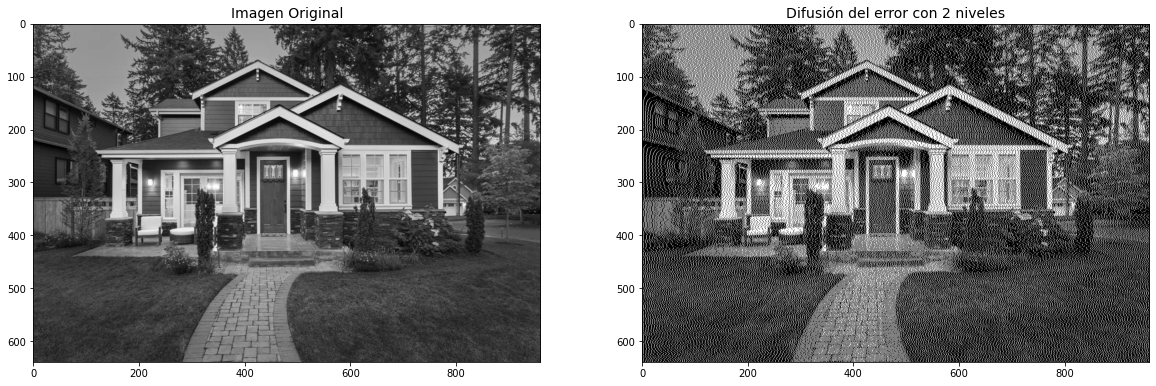

Button(description='SAVE OUTPUT', style=ButtonStyle())

Output()

In [25]:
#@title Seleccione la imagen a analizar: { run: "auto" }
torax = 'https://faros.hsjdbcn.org/sites/default/files/styles/ficha-contenido/public/radiografia_de_torax_-_imagen_-.jpg?itok=-Nikjhh3'
casa = 'https://thumbor.forbes.com/thumbor/960x0/https%3A%2F%2Fspecials-images.forbesimg.com%2Fimageserve%2F1026205392%2FBeautiful-luxury-home-exterior-at-twilight%2F960x0.jpg%3Ffit%3Dscale'

Imagen = 'casa' #@param ["torax", "casa"]

if Imagen =='torax':
  image_1 = get_image(torax)
if Imagen =='casa':
  image_1 = get_image(casa)

#@markdown Seleccione el método de cuantización: { run: "auto" }
Metodo = 'difusion_del_error' #@param ["uniforme", "dithering_aleatorio", "difusion_del_error"]

#@markdown Seleccione la cantidad de niveles para la cuantización: { run: "auto" }
Niveles = 2 #@param {type:"slider", min:2, max:16, step:1}

if Metodo == 'uniforme':
  uniform_image = quantize_uniform(image_1,Niveles)
  plot_2images(image_1, 'Imagen Original', uniform_image, f'Cuantización Uniforme con {Niveles} niveles')
  image_out = np.copy(uniform_image)

if Metodo == 'dithering_aleatorio':
  dithering_image = random_noise(image_1,0.05)
  dithering_image_out = quantize_uniform(dithering_image,Niveles)
  plot_2images(image_1, 'Imagen Original', dithering_image_out, f'Dithering aleatorio con {Niveles} niveles')
  image_out = np.copy(dithering_image)

if Metodo == 'difusion_del_error':
  diffusion_image = error_diffusion(image_1,Niveles)
  diffusion_image_out = quantize_uniform(diffusion_image,Niveles)
  plot_2images(image_1, 'Imagen Original', diffusion_image_out, f'Difusión del error con {Niveles} niveles')
  image_out = np.copy(diffusion_image)

print('\n')
save_button(image_out, '/content/output_image.png', 'SAVE OUTPUT')

##5. Resultados del Remuestreo y Reconstrucción

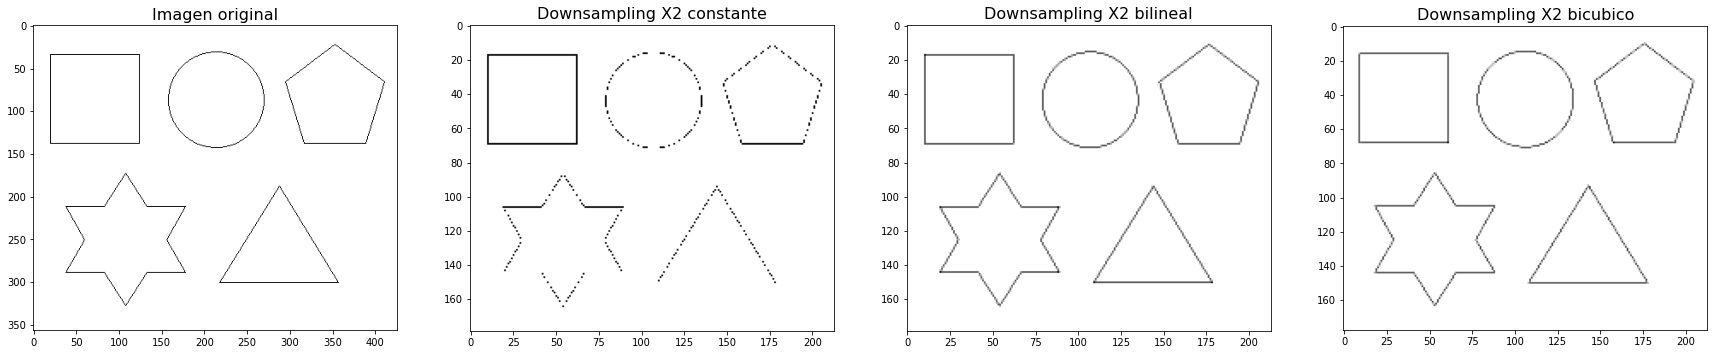

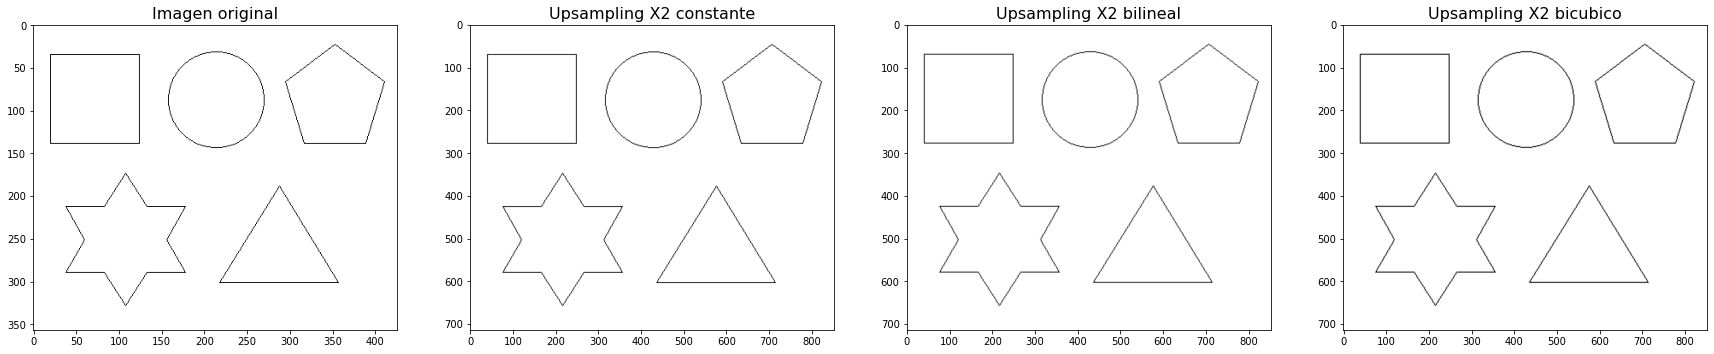

In [26]:
shapes_link = '/content/drive/MyDrive/Cursos_Posgrado/Procesamiento_Imagenes-UNS/TP8/formas.png'
image = get_image(shapes_link)

plot_4images(image,'Imagen original', downsampling('constante',image),'Downsampling X2 constante', downsampling('bilineal',image), 'Downsampling X2 bilineal', downsampling('bicubico',image), 'Downsampling X2 bicubico')

plot_4images(image,'Imagen original', upsampling('constante',image),'Upsampling X2 constante', upsampling('bilineal',image), 'Upsampling X2 bilineal', upsampling('bicubico',image), 'Upsampling X2 bicubico')

##5.1. Conclusiones del Remuestreo y Reconstrucción

* Se observa como el downsampling X2 cumple su función escencial de disminuir a la mitad las dimensiones de la imagen.

* Observamos el deficiente resultado obtenido con el kernel constante, en especial para aquellas figuras que no poseen bordes rectos (horizontales o verticales), dado que al considerar 1 solo pixel cada 4, no es posible reconstruir correctamente aquellas imágenes que posean líneas con un cierto ángulo.

* En el caso del kernel bilineal observamos una mejora considerable con respecto a lo mencionado anteriormente, pero con las líneas un poco mas gruesas que la original. Este defecto se reduce un poco más al considerar el kernel bicúbico.

* Se observa como el upsampling X2 funciona correctamente, al aumentar al doble las dimensiones de la imagen original.

* En cuanto a las distintas técnicas de upsampling (con kernel constante, bilineal y bicúbico) se observa como a medida que seleccionamos dichos kernels, la imagen pareciera tener mayor definición, con los bordes mas nítidos.


##6. Resultados de la Cuantización

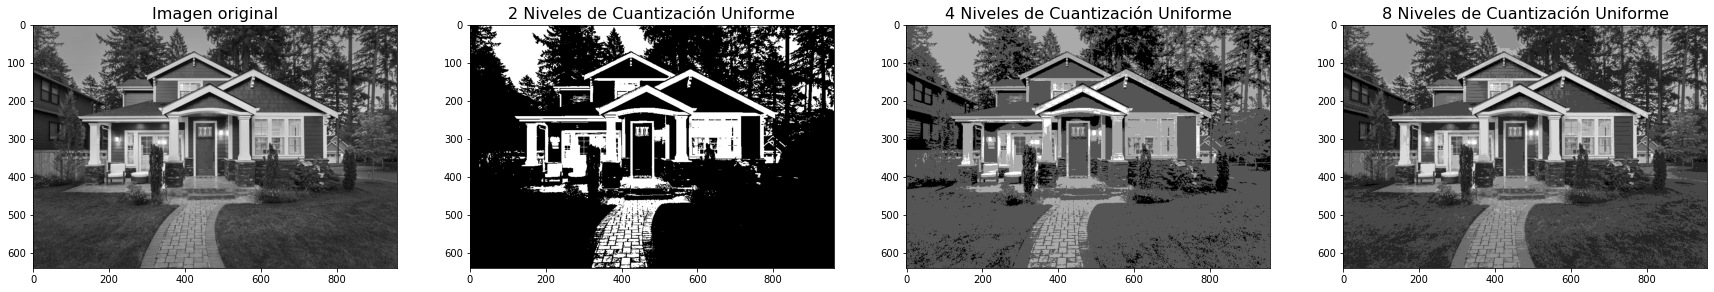

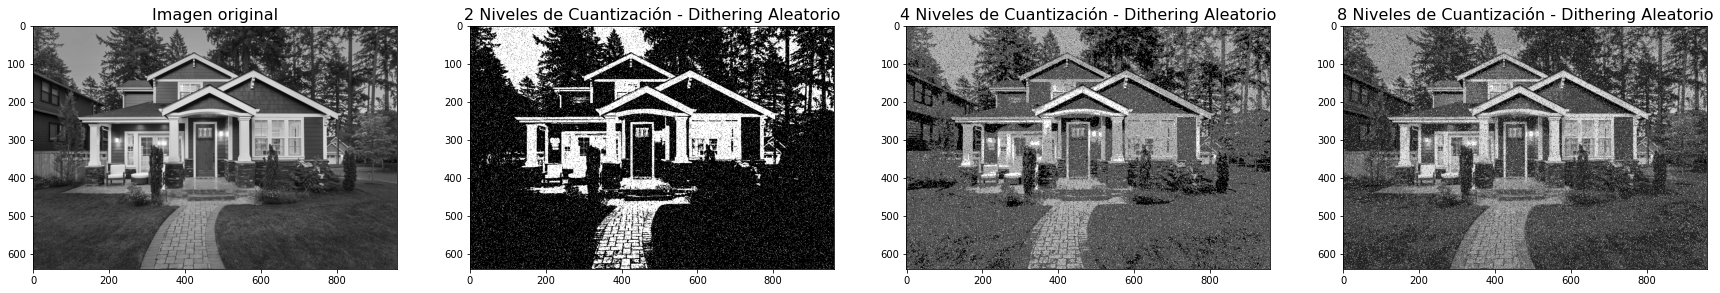

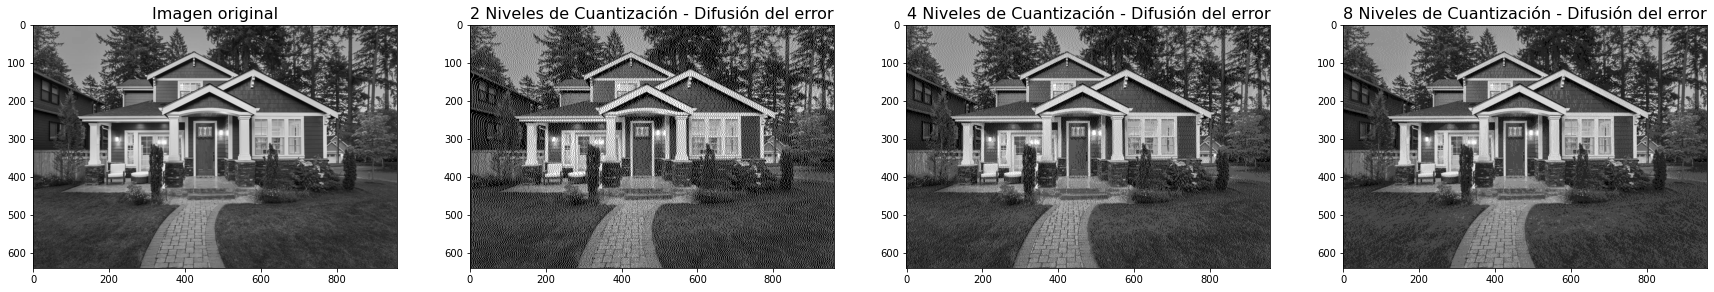

In [27]:
house = 'https://thumbor.forbes.com/thumbor/960x0/https%3A%2F%2Fspecials-images.forbesimg.com%2Fimageserve%2F1026205392%2FBeautiful-luxury-home-exterior-at-twilight%2F960x0.jpg%3Ffit%3Dscale'
image_1 = get_image(house)

plot_4images(image_1,'Imagen original', quantize_uniform(image_1,2),'2 Niveles de Cuantización Uniforme', quantize_uniform(image_1,4),'4 Niveles de Cuantización Uniforme', quantize_uniform(image_1,8), '8 Niveles de Cuantización Uniforme')

dithering_image_1 = random_noise(image_1,0.05)
dithering_image_2 = random_noise(image_1,0.05)
dithering_image_3 = random_noise(image_1,0.05)

diffusion_image_1 = error_diffusion(image_1,2)
diffusion_image_2 = error_diffusion(image_1,4)
diffusion_image_3 = error_diffusion(image_1,8)

plot_4images(image_1,'Imagen original', quantize_uniform(dithering_image_1,2),'2 Niveles de Cuantización - Dithering Aleatorio', quantize_uniform(dithering_image_2,4),'4 Niveles de Cuantización - Dithering Aleatorio', quantize_uniform(dithering_image_3,8), '8 Niveles de Cuantización - Dithering Aleatorio')

plot_4images(image_1,'Imagen original', quantize_uniform(diffusion_image_1,2),'2 Niveles de Cuantización - Difusión del error', quantize_uniform(diffusion_image_2,4),'4 Niveles de Cuantización - Difusión del error', quantize_uniform(diffusion_image_3,8), '8 Niveles de Cuantización - Difusión del error')

##6.1. Conclusiones de la Cuantización

* Se pudo aplicar satisfactoriamente la cuantización uniforme, observando que los mejores resultados, y aquellos que nos permiten diferenciar características de la imagen, se obtienen empleando niveles de cuantización de 8 o mayores.

* Al aplicar dithering aleatorio y cuantizar la imagen, observamos como necesitamos menores niveles de cuantización en comparación con la cuantización sin aplicar dithering, ya que con 4 niveles ya se pueden apreciar detalles de la imagen (por ejemplo en la zona del bosque detrás de la casa o en las plantas al frente).

* Por último se observa la notable diferencia al aplicar la difusión del error antes de cuantizar la imagen. Con solo 2 niveles de cuantización se aprecian detalles de la casa para los cuales fueron necesarios 4 u 8 niveles de cuantización empleando las técnicas anteriores. Si bien la difusión del error puede requerir mas capacidad de cómputo, los resultados son bastante mejores en comparación con las demás técnicas analizadas.